# CNN Architectures

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import tempfile

2025-06-27 23:41:00.586331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Pipeline

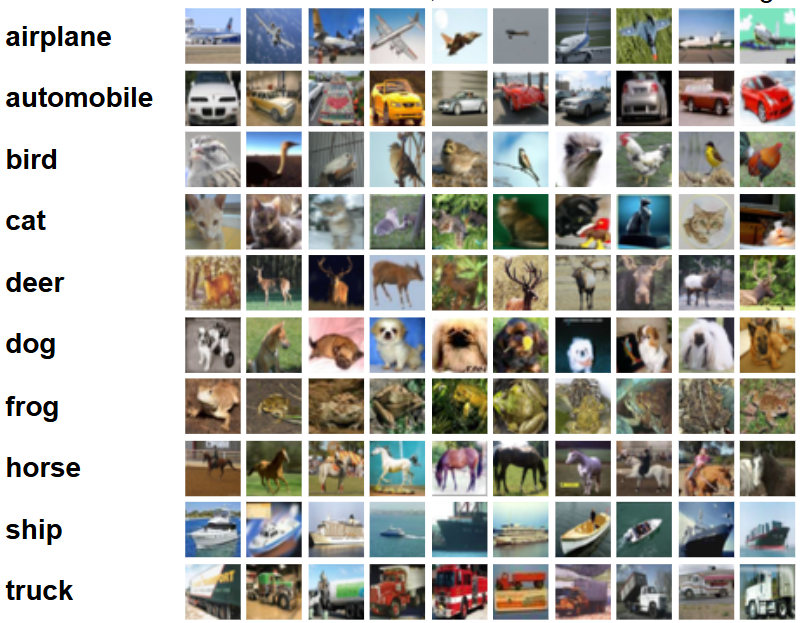

https://www.cs.toronto.edu/%7Ekriz/cifar.html

In [3]:
# Load CIFAR-100
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [4]:
# Data preprocessing functions
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [5]:
def augment_img(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

In [7]:
# Create tf.data pipelines
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE


train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))\
    .shuffle(10000)\
    .map(augment_img, num_parallel_calls=AUTOTUNE)\
    .map(normalize_img, num_parallel_calls=AUTOTUNE)\
    .batch(BATCH_SIZE)\
    .prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))\
    .map(normalize_img, num_parallel_calls=AUTOTUNE)\
    .batch(BATCH_SIZE)\
    .prefetch(AUTOTUNE)

2025-06-27 20:34:00.927579: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153600000 exceeds 10% of free system memory.


# CNN Architectures

- Simple CNN
- VGG
- ResNet
- Inception

## Simple CNN model

In [6]:
def build_simple_cnn():
    model = models.Sequential([
        layers.Conv2D(32, 3, activation='relu', input_shape=(32,32,3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(100, activation='softmax')
    ])
    return model

## VGG CNN

In [7]:
def build_vgg():
    model = models.Sequential([
        layers.Conv2D(64, 3, activation='relu', padding='same', input_shape=(32,32,3)),
        layers.BatchNormalization(),

        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dense(100, activation='softmax')
    ])
    return model

## ResNet architecture

In [8]:
def build_resnet():
    inputs = layers.Input(shape=(32,32,3))
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    y = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    y = layers.BatchNormalization()(y)

    x = layers.add([x, y])

    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    y = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    y = layers.BatchNormalization()(y)
    
    x = layers.add([x, y])
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(100, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

## Inception model

In [9]:
def inception_module(x, filters):
    path1 = layers.Conv2D(filters, 1, padding='same', activation='relu')(x)
    path2 = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    path3 = layers.Conv2D(filters, 5, padding='same', activation='relu')(x)
    path4 = layers.MaxPooling2D(3, strides=1, padding='same')(x)
    path4 = layers.Conv2D(filters, 1, padding='same', activation='relu')(path4)
    return layers.concatenate([path1, path2, path3, path4], axis=-1)

def build_inception():
    inputs = layers.Input(shape=(32,32,3))
    x = inception_module(inputs, 32)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = inception_module(x, 64)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(100, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

## Visualize Model Architectures

In [1]:
tf.keras.utils.plot_model(build_inception(), show_shapes=True, dpi=1000)

NameError: name 'tf' is not defined

/opt/conda/envs/py39_tensorflow/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Simple CNN summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 327,716 (1.25 MB)

 Trainable params: 327,524 (1.25 MB)

 Non-trainable params: 192 (768.00 B)

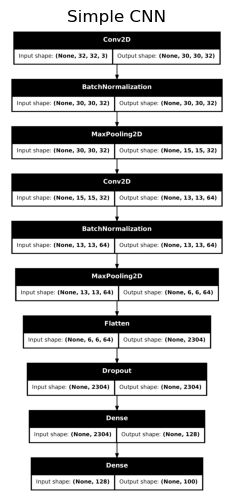


 ++++++++++++++++++ ++++++++++++++++++


VGG summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,384,804 (9.10 MB)

 Trainable params: 2,384,036 (9.09 MB)

 Non-trainable params: 768 (3.00 KB)

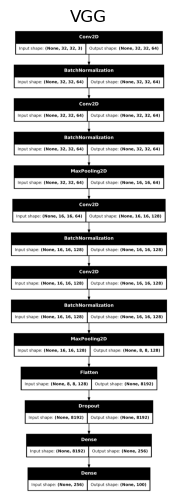


 ++++++++++++++++++ ++++++++++++++++++


ResNet summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 64)  │          0 │ add_1[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4096)      │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4096)      │          0 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    524,416 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 100)       │     12,900 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 603,652 (2.30 MB)

 Trainable params: 603,268 (2.30 MB)

 Non-trainable params: 384 (1.50 KB)

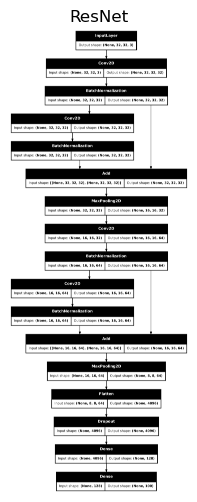


 ++++++++++++++++++ ++++++++++++++++++


Inception summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32, 3) │          0 │ input_layer_3[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │        128 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │      2,432 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │        128 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_10[0][0],  │
│ (Concatenate)       │ 128)              │            │ conv2d_11[0][0],  │
│                     │                   │            │ conv2d_12[0][0],  │
│                     │                   │            │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 16, 16,    │          0 │ max_pooling2d_7[… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16,    │      8,256 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 16,    │     73,792 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 16, 16,    │    204,864 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 16, 16,    │      8,256 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ conv2d_14[0][0],  │
│ (Concatenate)       │ 256)              │            │ conv2d_15[0][0],  │
│                     │                   │            │ conv2d_16[0][0],  │
│                     │                   │            │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,410,468 (9.20 MB)

 Trainable params: 2,409,700 (9.19 MB)

 Non-trainable params: 768 (3.00 KB)

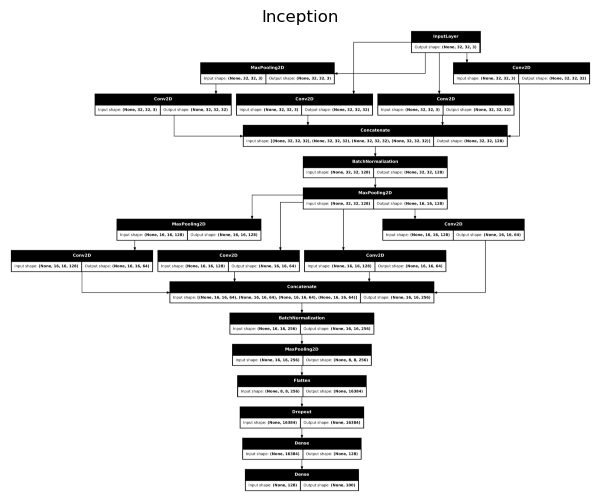


 ++++++++++++++++++ ++++++++++++++++++



In [10]:
models_dict = {
    'Simple CNN': build_simple_cnn(),
    'VGG': build_vgg(),
    'ResNet': build_resnet(),
    'Inception': build_inception()
}

for name, model in models_dict.items():
    print(f"\n{name} summary:")
    model.summary()
    # Plot model architecture
    plot_file = tempfile.mktemp(suffix='.png')
    tf.keras.utils.plot_model(model, to_file=plot_file, show_shapes=True, dpi=300)
    img = plt.imread(plot_file)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(name)
    plt.show()
    print("\n ++++++++++++++++++ ++++++++++++++++++\n")

## Train Architectures

In [ ]:
EPOCHS = 10
histories = {}

for name, model in models_dict.items():
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    print(f"\nTraining {name}...")
    history = model.fit(train_ds, validation_data=test_ds, 
                        epochs=EPOCHS, 
                        steps_per_epoch=10, 
                        verbose=2)
    histories[name] = history


Training Simple CNN...
Epoch 1/10


10/10 - 5s - 476ms/step - accuracy: 0.0234 - loss: 5.5304 - val_accuracy: 0.0125 - val_loss: 4.6044
Epoch 2/10
10/10 - 3s - 263ms/step - accuracy: 0.0266 - loss: 4.9388 - val_accuracy: 0.0103 - val_loss: 4.6021
Epoch 3/10
10/10 - 3s - 262ms/step - accuracy: 0.0188 - loss: 4.6728 - val_accuracy: 0.0161 - val_loss: 4.5990
Epoch 4/10
10/10 - 3s - 269ms/step - accuracy: 0.0359 - loss: 4.5938 - val_accuracy: 0.0223 - val_loss: 4.5838
Epoch 5/10
10/10 - 6s - 557ms/step - accuracy: 0.0312 - loss: 4.5090 - val_accuracy: 0.0268 - val_loss: 4.5585
Epoch 6/10
10/10 - 3s - 335ms/step - accuracy: 0.0469 - loss: 4.4456 - val_accuracy: 0.0244 - val_loss: 4.5541
Epoch 7/10
10/10 - 3s - 282ms/step - accuracy: 0.0484 - loss: 4.4231 - val_accuracy: 0.0226 - val_loss: 4.5568
Epoch 8/10
10/10 - 3s - 277ms/step - accuracy: 0.0391 - loss: 4.4538 - val_accuracy: 0.0266 - val_loss: 4.5730
Epoch 9/10
10/10 - 3s - 288ms/step - accuracy: 0.0469 - loss: 4.4500 - val_accuracy: 0.0242 - val_loss: 4.6268
Epoch 10/10


## Plot Learning Curves

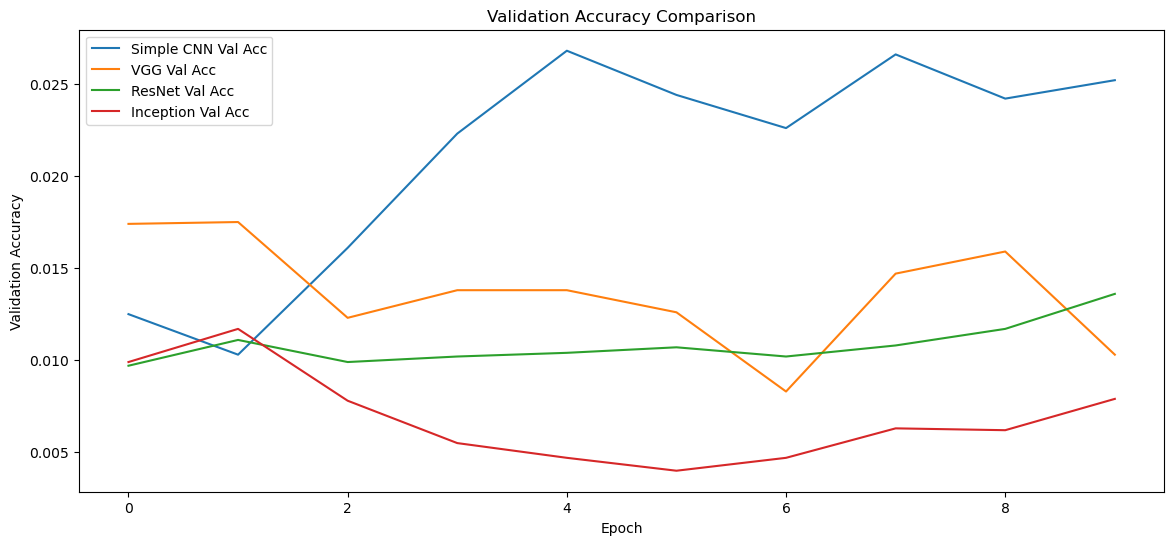

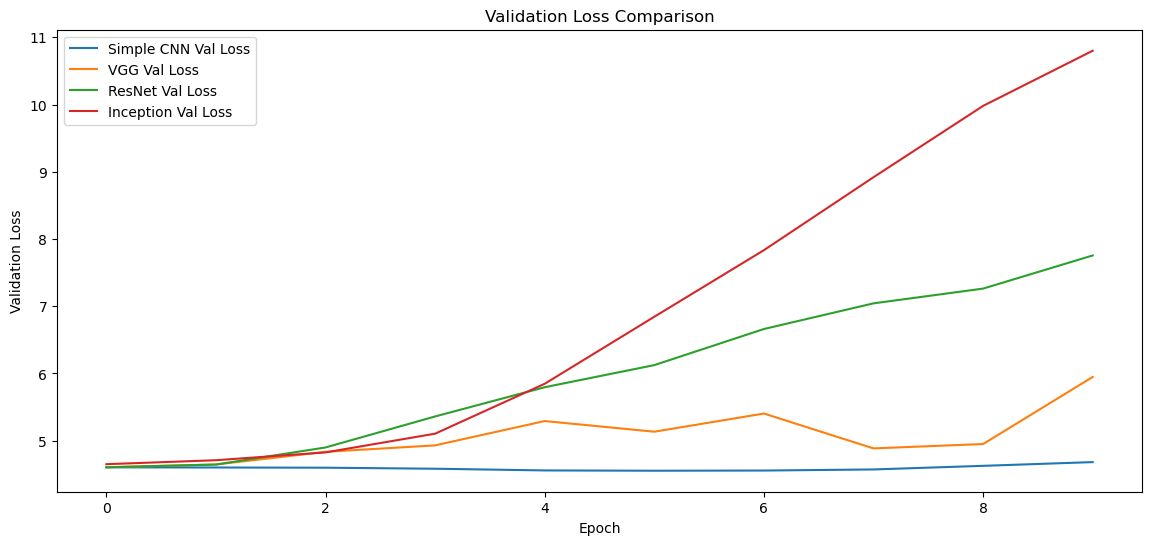

In [11]:
plt.figure(figsize=(14,6))
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f'{name} Val Acc')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
for name, history in histories.items():
    plt.plot(history.history['val_loss'], label=f'{name} Val Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()